## PART 4 - BASIC STOCK PRICE PREDICTION USING RNN 

Technical analysis is used to decide the most important factors that affect the stock and make a buy/sell decision. 

The entire procedure in this notebook consists of the following steps:

- Step 1 - Function to read data from file, prepare and extract required columns
- Step 2 - Function to normalize prepared data
- Step 3 - Function to convert data to time-series format.
- Step 4 - Function to build RNN - LSTM model
- Step 5 - Function to train RNN - LSTM model
- Step 6 - Function to predict prices from RNN - LSTM model
- Step 7 - Function to visualize results of RNN - LSTM model
- Step 8 - Function to evaluate RNN - LSTM model

### Results -  The predictive model was applied on the following stocks and analyzed

    1. Apple
    2. IBM
    3. Goldman Sachs
    4. Amazon
    5. General Electric
    6. Google <br>


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
print(tf.__version__) #1.3.0
print(keras.__version__) #2.2.0
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.merge import concatenate, add
from keras.layers.recurrent import LSTM, GRU
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from sklearn.metrics import accuracy_score as acc
from scipy import stats
from keras.models import model_from_json

The stock analysis was done on the following companies

- Apple
- IBM
- Goldman Sachs
- Amazon 
- General Electric
- Google 


The following steps have been taken in creating a predictive stock market model:

- Data preparation for time - series stock market model
- Building the model
- Training the model
- Predicting the stock prices 
- Evaluating the model
- Visualizing the model

### DATA PREPARATION FOR TIME-SERIES STOCK MARKET PREDICTIVE MODEL

#### 1. Function to read data from file, prepare and extract required columns

In [1]:
# Get rid of , in the Volume, then convert it to a float

def volume_to_float(volume_str):
    
    volume_str = str(volume_str)
    return float(volume_str.replace(",",""))


def data_preparation(data_path, columns_list):
    
    # Importing the training set
    dataset_original = pd.read_csv(data_path)
    dataset_original['Volume'] = dataset_original['Volume'].apply(volume_to_float)

    #Choose the columns to create training set
    # 1,6 refers to  the 2nd and 7th column with column indices(1 - CLOSE, 6 - EMA
    training_set = dataset_original.iloc[:, columns_list].values

    print("Shape of train set",np.shape(training_set))
    print("\nTrain dataset head\n")
    print(dataset_original.head(5))
    
    return training_set, dataset_original

#### 2. Function to normalize prepared data

In [3]:
def normalize_data(training_set):
    print("\n")
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    print(np.shape(training_set_scaled))
    print("\n")
    print(training_set_scaled)
    print("\n\n")
    return training_set_scaled, sc 

#### 3. Function to convert data to time-series format 


#####  Input shape of a 3D tensor
3D tensor with shape (batch_size, timesteps, input_dim)

This reshaping is necessary to add additional indicators over the OPEN stock price


Here we are using batchsize = whole dataset, timesteps = 60, and 1 additional indictor

In [4]:
# Creating a data structure with 120 timesteps and 1 output (We use the CLOSE prices here)
# Set X-train's columns to all the columns needed in the train data, in this example it's 0:2, CLOSE and VOLUME 
# y_train contains only the Target variable ( CLOSE price based on the previous no of timesteps)

def time_series_convert(training_set_scaled, no_timesteps, total_obs, target_column, input_features):
    X_train = []
    y_train = []
    for i in range(no_timesteps, total_obs):
        
        #120 prior rows and all the columns over those observations forms 1 observation 
        X_train.append(training_set_scaled[i - no_timesteps:i, 0:])
        
        #1 target of CLOSE PRICE Of next day 
        y_train.append(training_set_scaled[i, target_column])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    #Each of the 1390 observations will have 120 x 7 values and 1 target variable
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], input_features))
    print("X_train shape",X_train.shape)
    print("y_train shape",y_train.shape)
    print(pd.DataFrame(y_train).head())
    
    print("\n\n Checking 1 Observation \n")
    print(X_train[0], y_train[0])
    return X_train, y_train

### BUILD, TRAIN, TEST, EVALUATE AND VISUALIZE THE MODEL

Stock market is affected by a lot of factors and we need more of those factors to be captured by the neurons. Therefore we need an LSTM layer with high dimensionality. Choosing a low number of neurons will not capture the upward and downward trends properly. To get high dimensionality, we use a high number of neurons and high number of layers. 

Return Sequence is set to true when there is another LSTM layer following the current LSTM layer. 

We are using the mean_squared_error because we are doing some regression and predicting a continuous value. Even though the rms_prop optimizer is the recommended optimizer for Recurrent Neural Networks, through experimentation we find out that the Adam optimizer performs better on our implementation. It's very powerful and performs relevant weight updates

We are using the epochs = 100, because we notice that the loss converges for that many number of epochs. We also don't want to increase the epochs too much in a way that it overfits to the training data. We found this to be the optimal number of epochs that predict the stock price accurately


#### 4. Function to build RNN - LSTM model

In [5]:
def build_rnn_model(X_train, input_features):
    
    regressor = Sequential()
    
    # Adding the first LSTM layer and some Dropout regularisation
    # Three important paramaters - Number of units,  return sequences, input shape 
    regressor.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], input_features)))
    regressor.add(Dropout(0.3))
    
    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120, return_sequences = True))
    regressor.add(Dropout(0.3))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120, return_sequences = True))
    regressor.add(Dropout(0.3))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120, return_sequences = True))
    regressor.add(Dropout(0.3))

    # Adding a fifth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120))
    regressor.add(Dropout(0.3))

    regressor.add(Dense(32, kernel_initializer="uniform",activation='relu'))        

    # Adding the output layer, we have one output value, that is output of only one dimension  
    # We are adding a fully connected output layer 
    regressor.add(Dense(units = 1))  
    
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    print("regressor model built and compiled...")
    return regressor

#### 5. Function to train RNN - LSTM model


In [7]:
def train_model(regressor, X_train, y_train, epochs = 20):
    
    print("\ntraining started...")
    print(regressor.summary())
    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 32, epochs = epochs, validation_split = 0.15, shuffle = True) 
    return regressor

#### 6. Function to predict prices from RNN - LSTM model


##### Important steps I took to ensure that we get relevant predictions 

-  As we know, the we are trying to predict stock prices for the month of January 2018, and our model is built in such a way that the input requires data of previous 60 financial days. 


-  And we know our test set contains values of only that month of January that is (20 days)


-  So we can NORMALIZE all the test data and give it as inputs into our model, However this approach is NOT RIGHT because we are not taking the context of the Train normalization into consideration. 


-  To overcome this, we need to concatenate the TEST and TRAIN data, perform the NORMALIZATION over the entire dataset and then extract the inputs that are required for the prediction. 

In [8]:
def test_model(regressor, data_path_test, dataset_train, columns, sc, sc_close, no_timesteps):
    
    dataset_test = pd.read_csv(data_path_test)
    print(dataset_test.head(3))
    real_stock_price = dataset_test.iloc[:, 1:2].values
    dataset_total = pd.concat((dataset_train[columns], dataset_test[columns]), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(dataset_test) - no_timesteps:].values
    
    #Change the input shape according to the number of indicators, here 2 means 2 indicators 
    inputs = inputs.reshape(-1,7)
    inputs = sc.transform(inputs)
    print("\ninputs\n")
    print(inputs)
    
    X_test = []
    for i in range(no_timesteps, no_timesteps + 21):
        X_test.append(inputs[i-no_timesteps:i, 0:])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], input_features))
    print("\n X_test \n")
    print(X_test.shape)
    print(X_test)
    
    predicted_stock_price = regressor.predict(X_test)
    # Create lists to measure if opening price increased or decreased
    real_stock_price_transformed = sc_close.transform(real_stock_price)
    direction_pred = []
    
    #Getting the directions of the stock price movement
    print("Normalized Predicted Prices")
    print(np.mean(predicted_stock_price), stats.mode(predicted_stock_price), np.median(predicted_stock_price))
    for pred in predicted_stock_price_transformed:
        print(pred)
        if np.around(pred,1) >= np.around(np.mean(real_stock_price_transformed),1):
            direction_pred.append(1)
        else:
            direction_pred.append(0)
            
    print("Normalized Real Stock Prices")
    print(np.mean(real_stock_price_transformed), stats.mode(real_stock_price_transformed), np.median(real_stock_price_transformed))

    direction_test = []
    for value in real_stock_price_transformed:
        print(value)
        if np.around(value, 1) >= np.around(np.mean(real_stock_price_transformed), 1):
            direction_test.append(1)
        else:
            direction_test.append(0)
    print("\n\n")        
    predicted_stock_price = sc_close.inverse_transform(predicted_stock_price)
    print("Real stock prices on test data\n")
    print(real_stock_price)
    print("Final predicted stock prices on test data\n")
    print(predicted_stock_price)
    
    return real_stock_price, predicted_stock_price, direction_test, direction_pred

#### 7. Function to visualize results of RNN - LSTM model

In [9]:
def visualize_model(real_stock_price, predicted_stock_price, direction_test, direction_predict):

    # Visualising the results
    plt.figure(figsize=(14, 5), dpi=100)
    plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

#### 8. Function to evaluate RNN - LSTM model

Since we are doing a Regression on the values, the evaluation metric is RMSE - Root Mean Square Error. 
However, that metric computes the difference in errors and our main interest lies in analyzing the trends of the stock market and not getting the exact values. Therefore, the evaluation metric is not a strong one, however we still compute to check the results. 

In [10]:
def evaluate_model(real_stock_price, predicted_stock_price, direction_test, direction_pred):
    
    rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    avg = real_stock_price.mean()
    rmse = rmse/avg
    
    print(rmse)
    print("Prediction Direction", direction_pred)
    print("Real Direction",direction_test)
    direction = acc(direction_test, direction_pred)
    direction = round(direction,4)*100
    print("Predicted values matched the actual direction {}% of the time.".format(direction))
    return rmse, direction

In [11]:
def data_load_prepare(data_path, columns_list):
    


    # Data is prepared according to the conditions
    training_set, dataset_original = data_preparation(data_path = data_path, columns_list = columns_list)

    # Data is normalized over all attributes 
    training_set_scaled, sc = normalize_data(training_set)
    training_set_close = dataset_original.iloc[:, 1:2].values
    training_set_scaled_close, sc_close = normalize_data(training_set_close)

    # Data is converted to time-series format 
    no_timesteps = 120
    total_obs = len(training_set_scaled)
    input_features = 7
    target_column = 0

    X_train, y_train = time_series_convert(training_set_scaled, no_timesteps, total_obs, target_column, input_features)
    
    return X_train, y_train, sc, sc_close, dataset_original

In [12]:
def load_rnn_model(json_path, weights_path):
    
    """
    with open('model_architecture.json', 'r') as f:
        model = model_from_json(f.read())

    model.load_weights('model_weights.h5')
    """
    
    # Model reconstruction from JSON file
    with open(json_path, 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(weights_path)
    
    return model 
    

<br>
<br>
## APPLE STOCK ANALYSIS

In [ ]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'AAPL'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)

In [ ]:
# Model Building and Training


epochs = 80
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol)+ '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

In [ ]:
# Testing the model 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA42', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)

In [ ]:
#Hyperparameter Tuning 

for learning_rate in [0.001, 0.002, 0.005]:
    for dropout in [0.2,0.3, 0.5]:
        model = build_rnn_model(X_train, input_features)
        print()
        print("Current model: LR={}, Dropout={}".format(
            learning_rate,dropout))
        print()
        save_best_weights = 'question_pairs_weights_lr={}_dropout={}.h5'.format(
            learning_rate,dropout)

        callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                     EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

        history = model.fit(X_train,
                            y_train,
                            batch_size=32,
                            epochs=1,
                            validation_split=0.15,
                            verbose=True,
                            shuffle=True,
                            callbacks = callbacks)
#Parameters ( Dropout = 0.3, Units in Layers = 120, Epochs = 90)

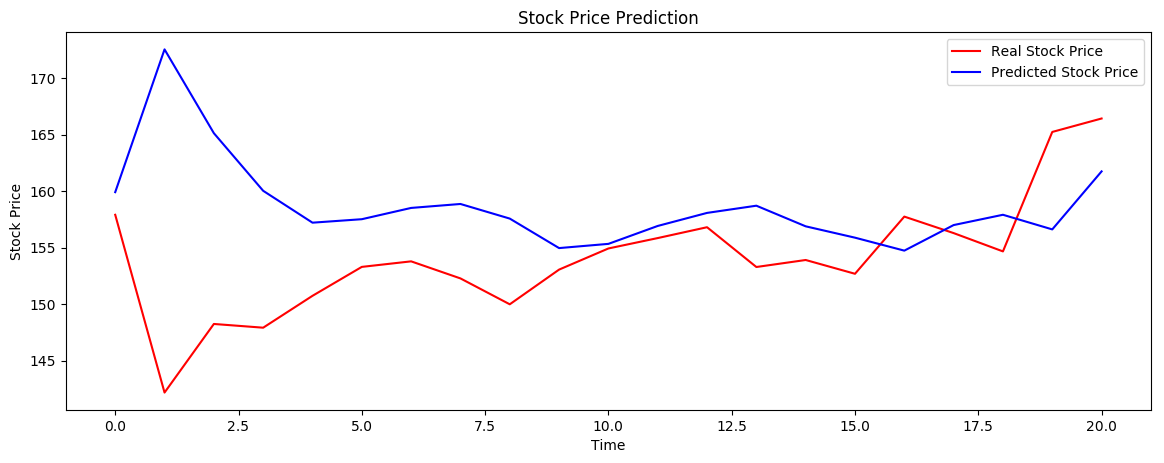

0.0585689587301
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 66.67% of the time.


(0.05856895873009995, 66.670000000000002)

In [56]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## IBM  STOCK ANALYSIS

In [81]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'IBM'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)

Shape of train set (1510, 7)

Train dataset head

         Date       Close     Volume         MA7        MA21        MA60  \
0  2013-01-02  196.350006  4234100.0  192.601430  192.382380  194.507167   
1  2013-01-03  195.270004  3644700.0  192.865716  192.658095  194.255167   
2  2013-01-04  193.990005  3380200.0  193.092861  192.878571  193.978501   
3  2013-01-07  193.139999  2862300.0  193.262861  193.092381  193.700500   
4  2013-01-08  192.869995  3026900.0  193.285716  193.243333  193.448500   

       MACD         EMA  
0  0.000000  196.350006  
1 -0.024231  195.540005  
2 -0.070568  194.466928  
3 -0.120602  193.571251  
4 -0.155995  193.101815  


(1510, 7)


[[ 0.82029016  0.10380173  0.79174903 ...,  0.84974444  0.63353821
   0.82602773]
 [ 0.81031139  0.08368377  0.79434236 ...,  0.84670076  0.63162254
   0.81836294]
 [ 0.79848473  0.0746556   0.79657123 ...,  0.84335916  0.6279592
   0.80820876]
 ..., 
 [ 0.0573778   0.16563358  0.00894347 ...,  0.01615848  0.38135773
   0

In [ ]:
# Model Building and Training


epochs = 20
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

In [83]:
dataset_test = pd.read_csv(data_path_test)
print(dataset_test.head(3))

         Date       Close   Volume         MA7        MA21        MA60  \
0  2019-01-02  115.209999  4239900  112.227142  117.430000  123.551334   
1  2019-01-03  112.910004  4346700  112.508571  116.889048  122.949334   
2  2019-01-04  117.320000  4477800  113.901428  116.508571  122.431500   

       MACD         EMA  
0  0.000000  115.209999  
1 -0.051602  113.485003  
2  0.071002  116.140001  


In [ ]:
# Testing the model 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA60', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)

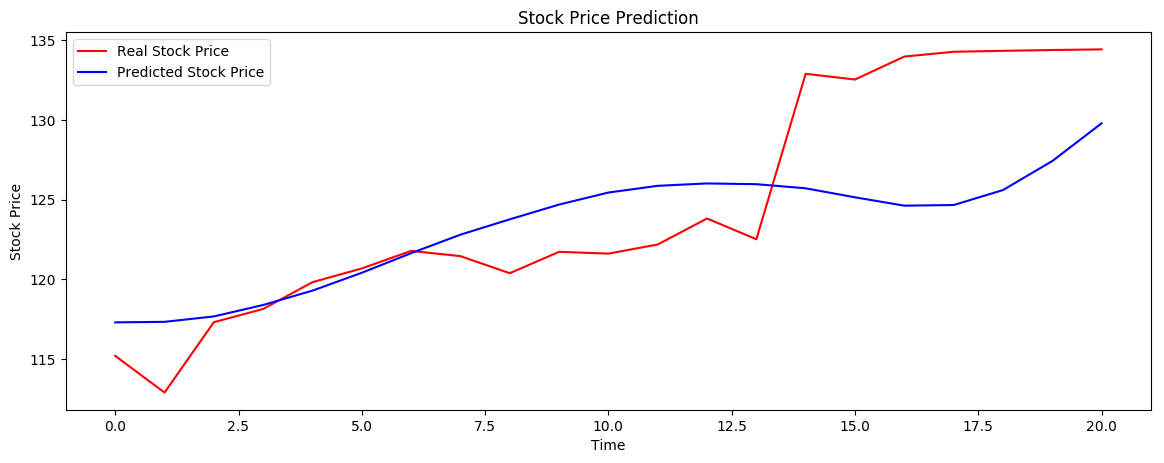

0.0400640889989
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 80.95% of the time.


In [85]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## GOLDMAN SACHS STOCK ANALYSIS 

In [ ]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'GS'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

In [ ]:
# Model Building and Training


epochs = 30
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

In [ ]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA60', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)

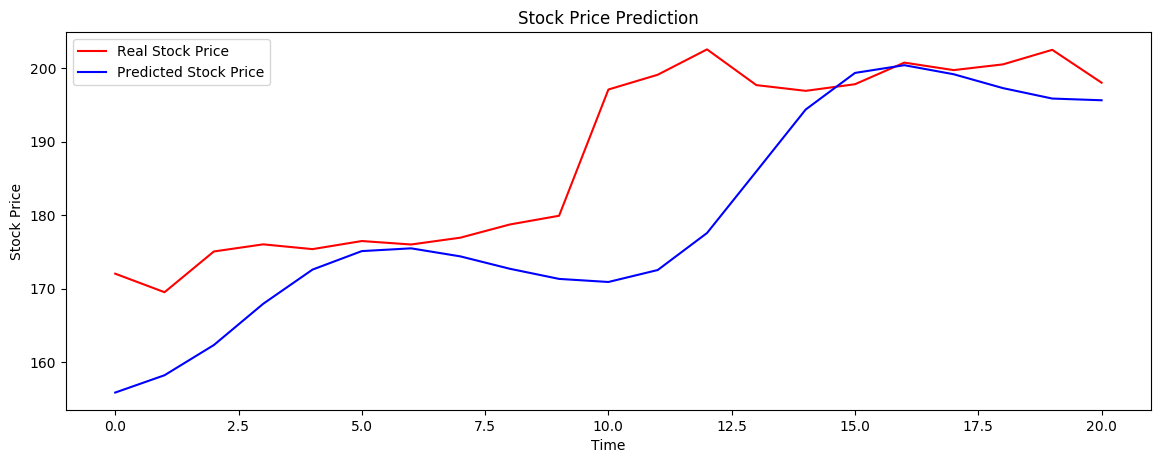

0.0631925556634
Prediction Direction [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 85.71% of the time.


In [96]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## AMAZON STOCK ANALYSIS

In [ ]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'AMZN'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

In [ ]:
# Model Building and Training


epochs = 15
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

In [ ]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA60', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)


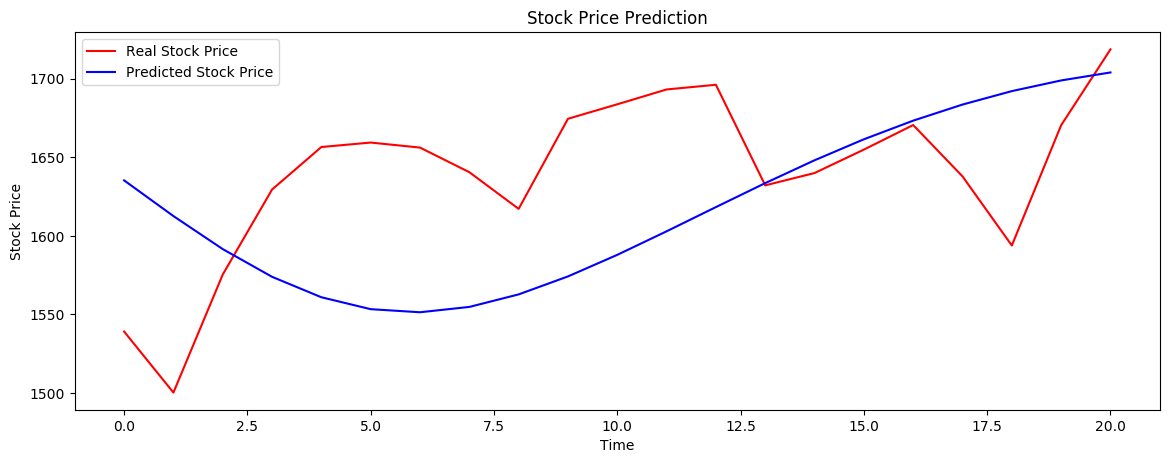

0.0447874653288
Prediction Direction [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 52.38% of the time.


In [16]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## GENERAL ELECTRIC STOCK ANALYSIS

In [ ]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'GE'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

In [ ]:
# Model Building and Training


epochs = 50
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

In [ ]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA42', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)


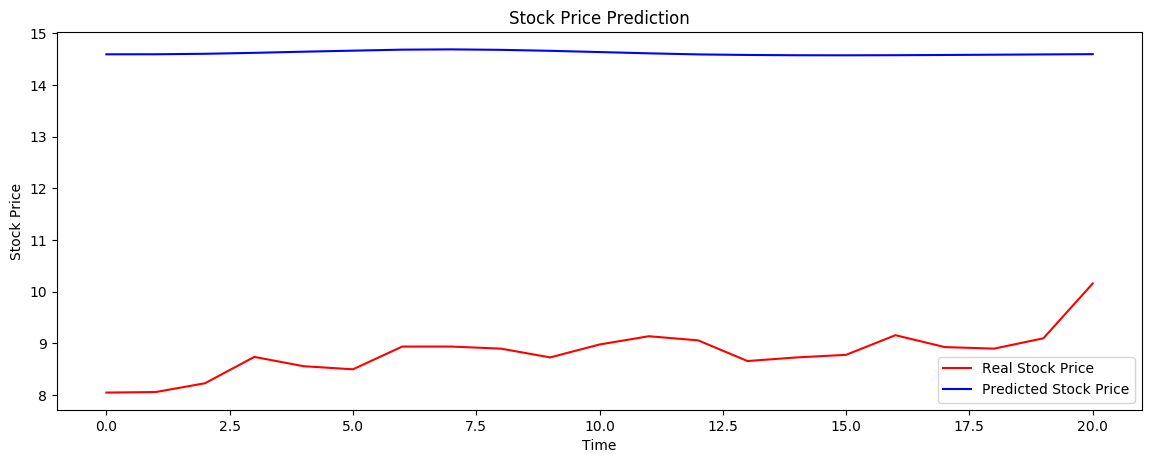

0.658892774872
Prediction Direction [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 100.0% of the time.


In [37]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## GOOGLE STOCK ANALYSIS

In [ ]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'GOOG'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

In [ ]:
# Model Building and Training


epochs = 80
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

In [ ]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA42', 'MA60', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)


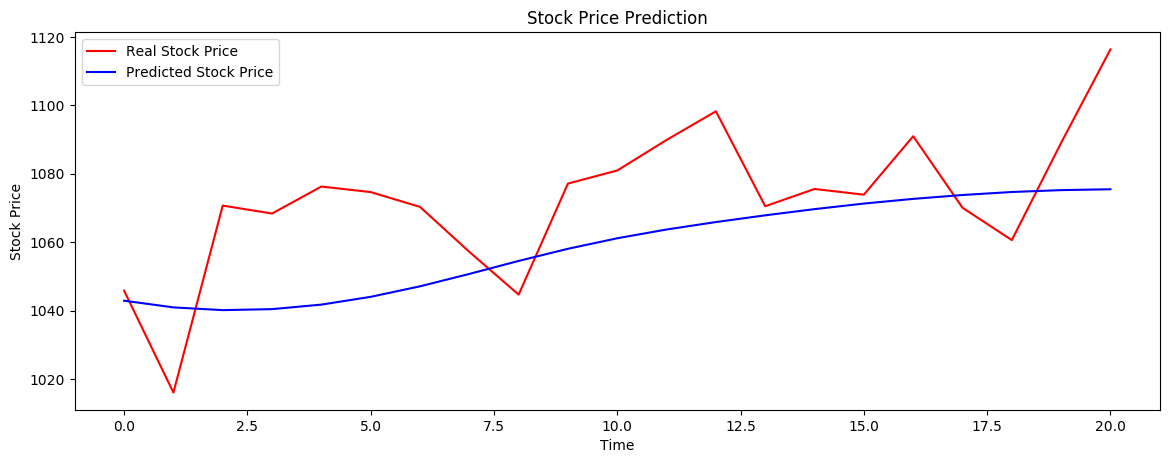

0.020448544494
Prediction Direction [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 95.24000000000001% of the time.


In [51]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)